<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
import io
import requests
url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

### Load Data From CSV File  

In [3]:
#df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

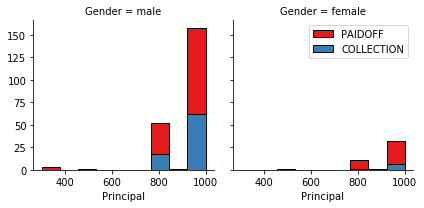

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

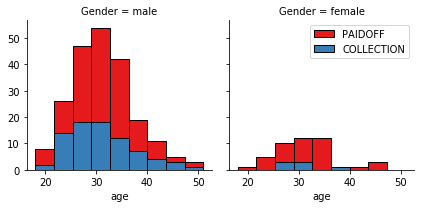

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

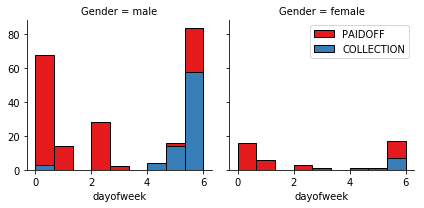

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dayofweek                  int64
weekend                    int64
dtype: object

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X = preprocessing.StandardScaler().fit_transform(X)
X[0:5]

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [21]:
from sklearn.model_selection import train_test_split
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
# Train model
k = 7
neighModel = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)

In [23]:
# Predict on test set
yhat = neighModel.predict(x_test)

In [24]:
from sklearn import metrics
# Check Model Accuracy
print("Training set accuracy: ", metrics.accuracy_score(y_train, neighModel.predict(x_train)))
print("Test set accuracy: ", metrics.accuracy_score(y_test, yhat))

Training set accuracy:  0.8079710144927537
Test set accuracy:  0.7857142857142857


In [25]:
# Iterate to find the best value of K
Ks = 20
mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))
confMat = [];

for n in range(1,Ks):
    neighModelIteration = KNeighborsClassifier(n_neighbors = n).fit(x_train, y_train)
    yhatIteration = neighModelIteration.predict(x_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhatIteration)
    
    std_acc[n-1]=np.std(yhatIteration==y_test)/np.sqrt(yhatIteration.shape[0])
    
mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       ])

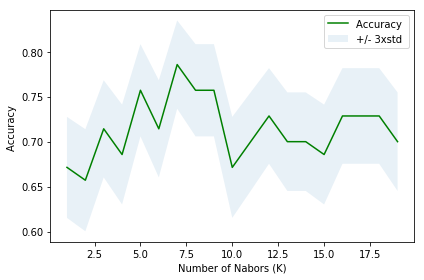

In [26]:
#Plot Data
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [27]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


# Decision Tree

In [33]:
#Import Decision Tree and Train_Test_Split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [51]:
# Create Tree and Fit Data
dTree = DecisionTreeClassifier(criterion="entropy", max_depth = 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)
dTree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
# Test on test set and check metrics
yHatDTree = dTree.predict(x_test)
print("Training set accuracy: ", metrics.accuracy_score(y_train, dTree.predict(x_train)))
print("Test set accuracy: ", metrics.accuracy_score(y_test, yHatDTree))

Training set accuracy:  0.7427536231884058
Test set accuracy:  0.7857142857142857


In [59]:
# Iterate to find the best value for max_depth
Ks = 20
mean_acc_DT = np.zeros((Ks - 1))
std_acc_DT = np.zeros((Ks - 1))
confMat_DT = [];

for n in range(1,Ks):
    dTreeIteration = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(x_train, y_train)
    yhatDTreeIteration = dTreeIteration.predict(x_test)
    mean_acc_DT[n-1] = metrics.accuracy_score(y_test, yhatDTreeIteration)
    
    std_acc_DT[n-1]=np.std(yhatDTreeIteration==y_test)/np.sqrt(yhatDTreeIteration.shape[0])
    
mean_acc_DT

array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.64285714,
       0.77142857, 0.75714286, 0.75714286, 0.65714286, 0.7       ,
       0.7       , 0.71428571, 0.7       , 0.72857143, 0.74285714,
       0.7       , 0.7       , 0.7       , 0.7       ])

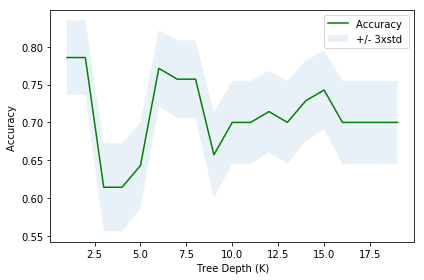

In [61]:
#Plot Data
plt.plot(range(1,Ks),mean_acc_DT,'g')
plt.fill_between(range(1,Ks),mean_acc_DT - 1 * std_acc_DT,mean_acc_DT + 1 * std_acc_DT, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Tree Depth (K)')
plt.tight_layout()
plt.show()

In [55]:
print( "The best accuracy was with", mean_acc_DT.max(), "with k=", mean_acc_DT.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 1


# Support Vector Machine

In [62]:
# Import SVM
from sklearn import svm

In [63]:
# Train Model and predict output
svmClass = svm.SVC(kernel = 'linear').fit(x_train, y_train)
yHatSVM = svmClass.predict(x_test)

In [64]:
# Print Accuracy Metrics
print("Training set accuracy: ", metrics.accuracy_score(y_train, svmClass.predict(x_train)))
print("Test set accuracy: ", metrics.accuracy_score(y_test, yHatSVM))

Training set accuracy:  0.7427536231884058
Test set accuracy:  0.7857142857142857


# Logistic Regression

In [97]:
# Import Model from sklearn and setup the data
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(penalty = 'l2', solver = 'lbfgs', max_iter = 100, C=0.01).fit(x_train, y_train)
yHatLogReg = logReg.predict(x_test)
print("Training set accuracy: ", metrics.accuracy_score(y_train, logReg.predict(x_train)))
print("Test set accuracy: ", metrics.accuracy_score(y_test, yHatLogReg))

Training set accuracy:  0.7427536231884058
Test set accuracy:  0.7857142857142857


# Model Evaluation using Test set

In [98]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [99]:
import io
import requests
url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

### Load Test set for evaluation 

In [100]:
test_df = df
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [101]:
#Format data
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [103]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [105]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [106]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize = True)

Gender  loan_status
0       PAIDOFF        0.744186
        COLLECTION     0.255814
1       PAIDOFF        0.727273
        COLLECTION     0.272727
Name: loan_status, dtype: float64

In [108]:
Feature_Test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_Test = pd.concat([Feature_Test,pd.get_dummies(test_df['education'])], axis=1)
Feature_Test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_Test.head()
X_TEST = Feature_Test
X_TEST = preprocessing.StandardScaler().fit_transform(X_TEST)
Y_TEST = test_df['loan_status'].values

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [114]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_TEST, Y_TEST, test_size = 0.2, random_state = 4)

In [121]:
#Run Models on data
train_acc_KNN = []
train_acc_DT = []
train_acc_SVM = []
train_acc_Log = []
test_acc_KNN = []
test_acc_DT = []
test_acc_SVM = []
test_acc_Log = []
Ks = 20
for n in range(1,Ks):
    KNN2 = KNeighborsClassifier(n_neighbors = n)
    train_acc = KNN2.fit(x_train_2, y_train_2)
    train_acc_KNN.append(train_acc.score(x_train_2, y_train_2))
    test_acc_KNN.append(train_acc.score(x_test_2, y_test_2))

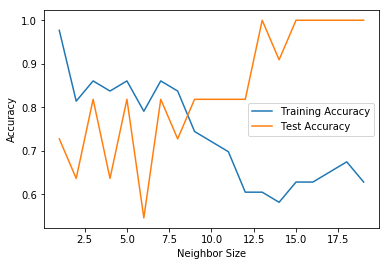

In [128]:
plt.plot(range(1,Ks), train_acc_KNN, label = 'Training Accuracy')
plt.plot(range(1,Ks), test_acc_KNN, label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Neighbor Size')
plt.legend()

In [153]:
# Model Metrics
KNN2 = KNeighborsClassifier(n_neighbors = 18).fit(x_train_2, y_train_2)
yHatKNN2 = KNN2.predict(x_test_2)
print("Training set accuracy: ", metrics.accuracy_score(y_train_2, KNN2.predict(x_train_2)))
print("Test set accuracy: ", metrics.accuracy_score(y_test_2, KNN2.predict(x_test_2)))

Training set accuracy:  0.6744186046511628
Test set accuracy:  1.0


In [159]:
dTree2 = DecisionTreeClassifier(max_depth = 3, random_state = 0).fit(x_train_2, y_train_2)
yHatDT2 = dTree2.predict(x_test_2)

In [160]:
print("Training set accuracy: ", metrics.accuracy_score(y_train_2, dTree2.predict(x_train_2)))
print("Test set accuracy: ", metrics.accuracy_score(y_test_2, dTree2.predict(x_test_2)))

Training set accuracy:  0.813953488372093
Test set accuracy:  0.45454545454545453


In [143]:
svmClass2 = svm.SVC(kernel = 'linear').fit(x_train_2, y_train_2)
yHatSVM2 = svmClass.predict(x_test_2)

In [145]:
# Print Accuracy Metrics
print("Training set accuracy: ", metrics.accuracy_score(y_train_2, svmClass2.predict(x_train_2)))
print("Test set accuracy: ", metrics.accuracy_score(y_test_2, yHatSVM2))

Training set accuracy:  0.7906976744186046
Test set accuracy:  0.9090909090909091


In [146]:
logReg2 = LogisticRegression(penalty = 'l2', solver = 'lbfgs', max_iter = 100, C=0.01).fit(x_train_2, y_train_2)
yHatLogReg2 = logReg.predict(x_test_2)
print("Training set accuracy: ", metrics.accuracy_score(y_train_2, logReg2.predict(x_train_2)))
print("Test set accuracy: ", metrics.accuracy_score(y_test_2, yHatLogReg2))

Training set accuracy:  0.6976744186046512
Test set accuracy:  0.9090909090909091


In [172]:
#OneHot y_test_2 for f1_score

y_test_2_HOT = pd.get_dummies(y_test_2)
yHatKNN2_HOT = (pd.get_dummies(yHatKNN2))
yHatDT2_HOT = (pd.get_dummies(yHatDT2))
yHatSVM2_HOT = (pd.get_dummies(yHatSVM2))
yHatLogReg2_HOT = (pd.get_dummies(yHatLogReg2))


In [185]:
y_test_2_HOT = y_test_2_HOT['PAIDOFF'].values
yHatKNN2_HOT = yHatKNN2_HOT['PAIDOFF'].values
yHatDT2_HOT = yHatDT2_HOT['PAIDOFF'].values

In [186]:
yHatSVM2_HOT = yHatSVM2_HOT['PAIDOFF'].values
yHatLogReg2_HOT = yHatLogReg2_HOT['PAIDOFF'].values

In [188]:
#Calcualte Scores
#KNN
jKNN = jaccard_similarity_score(y_test_2, yHatKNN2)
f1KNN = f1_score(y_test_2_HOT, yHatKNN2_HOT)

#DTree
jDT = jaccard_similarity_score(y_test_2, yHatDT2)
f1DT = f1_score(y_test_2_HOT, yHatDT2_HOT)

#SVM
jSVM = jaccard_similarity_score(y_test_2, yHatSVM2)
f1SVM = f1_score(y_test_2_HOT, yHatSVM2_HOT)

#Log-Reg
jLR = jaccard_similarity_score(y_test_2, yHatLogReg2)
f1LR = f1_score(y_test_2_HOT, yHatLogReg2_HOT)
llLR = log_loss(y_test_2, yHatLogReg2_HOT)

In [189]:
data = [['KNN', jKNN, f1KNN, 'NA'], ['Decision Tree', jDT, f1DT, 'NA'], ['SVM', jSVM, f1SVM, 'NA'], ['Logistic Regression', jLR, f1LR, llLR]] 
finalResult = pd.DataFrame(data, columns = ['Algorithm', 'Jaccard', 'F1-Score', 'Log Loss'])

In [190]:
finalResult.head()

,Algorithm,Jaccard,F1-Score,Log Loss
0,KNN,1.000000,1.000000,NA
1,Decision Tree,0.454545,0.625000,NA
2,SVM,0.909091,0.952381,NA
3,Logistic Regression,0.909091,0.952381,3.13996


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>